# 23 Long Term Treatment Effects

In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

## Climbing the Right Hill

Let's take a moment to review where we are at and what we've learned. First, we've learned to estimate the average treatment effect

$$
E[Y_1 - Y_0] \ \text{or} \ E[\partial{Y(t)}]
$$

This alowed us to say with confidence what was the effect size of our interventions on some target outcome we wished to change. The ATE tells us what would hapen, on average, if we change the treatment for everyone. For example, say the ATE of increasing prices in BRL 1.00 is decreasing products sold per month in 2 units. This would mean that, on average, customers would by 2 fewer products per month than they would have in the price didn't change. This **does not** mean that every customer will by 2 fewer units. Some might still by the same ammount. Some might by 10 units less. But, averaging all that out, sales should decrease 2 units. 

![img](./data/img/long-term-effect/ate.png)

After we covered the ATE, we learned about the conditional average treatment effect, or treatment effect heterogeneity

$$
E[Y_1 - Y_0 | X] \ \text{or} \ E[\partial{Y(t)}|X]
$$

where \\(X\\) is unit level caracteritics. The CATE alowed us to take into account that units respond differently to the same treatment. For example, some customers might not be very sensitive to price increases while others might be super sensitive. Modeling the conditional average treatment effect allow us to estimate this difference in sensitivity to the treatment on a unit level. 

![img](./data/img/long-term-effect/cate.png)

CATE estimation is also incredably powerfull because it allws us to personalise the treatment in a sound manner. We can give different treatments to different customers based on how well they respond to it. For example, we can increase price only for customers with high income level that are not very sensitive to price increases.

All in all, we can see that causal inference is an amazing tool to optimise any business strategy. With the ATE, we can understand which course of action or intervention would be better on average. With CATE we can personalise different interventions for different customers. 

So, we've covered how to estimate the impact of a treatment \\(T\\), how that impact can be differentiated by covariates \\(X\\), but we still haven't talked much about \\(Y\\). In my head, that is mildly concerning. We saw how causal inference can be an incredible tool for hill climbing a business objective, but all of it can be for nothing if we pick the wrong hill to climb.

[MEME]

Deciding the right thing to optimize is probably the most chalanging part of any new data science project, so I can't promisse an ultimate solution for everything. But I do hope that by discussing it, you will get a valuable intuition about how to approach the problem and the most common tools at your disposal. In this chapter, I'll walk you through the process of thinking about a solid \\(Y\\) to optimise and the causal inference chalanges that will come with it.

## Causal Inference Over Time
 
Consider the ubiquitous problem of deciding if some investment is worth it. Here, investment is a general term. It can be an investment in customer service to delight your customers, or an investment in marketing to acquire new customers, or an investment in management training. In any case, deciding to invest or not is, fundamentally, a causal inference problem. You have to consider what would happen under the investment (\\(Y_1\\)), contrast that with what would happen unde no investment (\\(Y_0\\)) and contrast both (\\(Y_1 - Y_0\\)). The problem is that some investments don’t pay off quickly. It takes time to see their effect.
 
To give a concrete example, first let’s consider the following situation. You are a company that provides software with a monthly subscription. On average, your customers stay with the company (pay the subscription) for 6 months, generating a net profit (costs - revenues) of about 5 BRL per month. Here is what the cashflow of a tipical customer (top) and the average cashflow (bottom) looks like

![img](./data/img/long-term-effect/cashflow_tipical_custo.png)


Now, you have to decide if you should start doing online advertisements to bring in more customers. If you do so, customers will still behave as before, but you will atract more of them. Also, your company will pay, on average BRL 20.00 to acquire a new customer through marketing (and, for the sake of simplicity, assume paid marketing trafict will not canibalize the organic trafic). If we look at the new cashflow for these new paid marketing customers, we see a huge negative event right at the begining, when the customer is aquired
 
![img](./data/img/long-term-effect/mkt_cashflow.png)

How do we know if the investment is worth it? Well, all we have to do is to compute the cumulative cashflow to see if the investment eventually pays of. So, since the initial investment is BRL 20 and the customer generates about BRL 5 per month, the cumulative cashflow will start at BRL -20 and increase BRL 5 per month. At month 4, it will reach zero, what we call a breakeven point. Then, the cashflow will turn positive. Eventually, the custumer will end his or her contract and the cumulative cashflow will stop growing. 

![img](./data/img/long-term-effect/cum_cashflow.png)

So, does the investment pays off? Well, it is not as obvious as it looks. The answer will depend largelly on how we define our outcome variable \\(Y\\). For example, let's say we define it to be the sum of net profits in the first three months. 

$$
y_i = \sum^3_{t=1} Profit_i
$$

In this case, the marketing investment is not worth it. In other words, the treatment effect of marketing is negative: \\(E[y(Marketing) - y(NoMarketing)] < 0\\). Ok, but what if we define \\(y\\) as the sum of net profits in the first 6 months? Well, now, the cumulative cashflow of the paid marketing customers had time to cross the breakeven point, turning positive. This means that the treatment effect of marketing is also positive: \\(E[y(Marketing) - y(NoMarketing)] > 0\\).

The key takwaay here is that whenever we are defining the outcome variable, **we have to come up with a time frame for it**. As we saw, that decision is far from inocuous. If we wait more time, we give more chance of upfront investments to pay off. In general, the longer we wait, the better our \\(y\\) will reflect the long term goals of a company. But there is a bitter price to pay for this. If we define \\(y\\) to be the sum of profits in the first 3 months, we have to wait at least 3 months to see if our treatment is worth it or not. If we define \\(y\\) to be the sum over 6 months, we have to wait at least 6 months. The longer our timeframe, the better our outcome reflects long term and strategic company goals. But the longer we have to wait to see if our treatment \\(T\\) works in influencing \\(Y\\), which means we will only be able to act on this information very slowly.

So, what can we do? We are caught between a rock and a hard place here. Like I said before, long term causal inference is a very chalanging topic, so I don't have any definitive answers. I do have some ideas though. First, I'm going to argue that we should define our outcome \\(Y\\) in such a way that it captures our business goal the best as possibly, even if it is a long term goal. Then, once that is defines, we will see how we can leverage early or short term proxies to estimate the treatment effect on a long term metric without having to wait all that long. 

### Picing the Right Time Window

In [35]:
np.random.seed(123)
y0 = np.concatenate([np.random.normal(100, 10, 20), [0,0,0]])
y1 = np.concatenate(([-40, -40, -20, -20, 0], np.repeat(30, 20-5), [0,0,0])) + y0

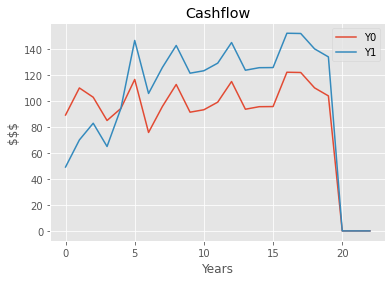

In [36]:
plt.plot(range(23), y0, label="Y0")
plt.plot(range(23), y1, label="Y1")

plt.title(f"Cashflow")
plt.legend()
plt.ylabel("$$$")
plt.xlabel("Years");

Because the investmen is costly, it reduces profits on the short term. This is why the blue line \\(Y_1\\) is below the red line \\(Y_1\\) on the short term. However, eventually, the investment takes effect and the potential profitablity under the investment cross the one under no investments. The fundamental question here is: is it worth it?

The answer will depend greatly on how we define the \\(Y\\) variable. If we define \\(Y\\) as being the total profit in the first 3 years, than no. If the define \\(Y\\) as being the total profit in the first 10 years, then yes. We can see that by ploting the cumulative profit per year to seen when \\(Y_1\\) crosses \\(Y_0\\).

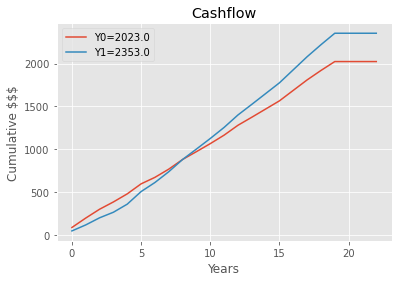

In [37]:
plt.plot(range(23), np.cumsum(y0), label="Y0="+str(np.sum(y0).round()))
plt.plot(range(23), np.cumsum(y1), label="Y1="+str(np.sum(y1).round()))

plt.title(f"Cashflow")
plt.legend()
plt.ylabel("Cumulative $$$");
plt.xlabel("Years");

So, depending on the timeframe we choose, the investment can have a positive or negative treatment effect. So, what time frame do we choose? 3 years and the effect of the investment will be negative? Or 10 years and then the effect will be positive? Honestly, whatever we choose will be a pretty arbitrary choice. Not only that, if we look closely, we can see clear trade-off between choosing a short or a long time period.

Whenever the treatment effect spans a long period of time, the longer the time frame we consider, the more acuralty will we measure the treatment effect. In our example, the treatment effect clearly pays of on the long run, so considering a short term period would be misleading. However, choosing a longer time frame to define our outcome \\(Y\\) variable also means it will take more time for us to measure it. For instance, let's say we define the outcome as profits in the first 10 years. This would mean that we would have to wait 10 years to see if our treatment is effective or not. 

The fact that whatever timeframe we choose is pretty arbitrary and that the long waiting time we will incurr for picking a longer time frame are both very serious and hard problems to solve whenever we thint about long term treatment effects. But that's exactly what makes it interesting. The next folowing chapter of this book will try to tackle these questions. Again, even though there isin't a general solution to this problem, I'm hoping to give you the tools to face these chalanges head on, giving them the proper atention they deserve, istead of simply throwing them under the rugh like many companies out there do. 

As a starting point, let's see what we can do about the fact that choosing a time frame is arbitraty. Fortunatly, there is an amazing Economic tool we can use to avoiding the choise all toguether. It's time we talk about Net Present Value. 

## Valuation Crash Course

I'm going to argue that the objective of any company (or firm as we call them in Economics), is profit maximisation. You can reply that some companies also care about social good, enviorement, ESG, yada yada. That might be true. Or not. (It could be only an elaborate marketing scheme to, once again, maximise profit). The point is, in this book, I'll go with the standard Economic theory which says that ["the social responsibility of business is to increase its profits"](https://en.wikipedia.org/wiki/Friedman_doctrine). Simply put, **profit is revenues minus costs**.

If profit is THE thing we are interested it, that makes it a good candidate for the outcome \\(Y\\) we wish to optimise with our tratment. This seems fairly obvious. What is still not obvious profits over which time frame? Over 3 years? 10 years? As we've argue before, the longer the time frame, the more precise our long treatment estimate will be. If we take this fact by hart, then there is an obvious timeframe we should choose: an infinite time frame!


### Discount Rates and Net Present Value

What?! That's crazy! We can't possibly compute an infinite time frame. What where you thinking?! I know, I know. First, we are forgeting the trade-off that the longer the time frame, the longer we have to wait to see the full treatment effect. Not to mention that it is simply impossible to compute anything over an infinite time frame. Or is it? Let's adress both of this problems in turn. First, let's see how we can at least compute the profitability over an infinite time horizon.

The trick is to realize the value of money in time. Think about it this way: whould you rather have BLR 1000.00 now or next year? Not a particularly hard question to answer right? Ok, next question: why do you prefer it now rather than latter? That's a more interesting. 

The answer lies in the fact that money changes value over time. Money rewards your for your patience and for delaying gratification. That's why if you take BRL 1000.00 now, invest it for one year, you will end up with more than BRL 1000.00. For instance, if the interest rate is 10% a.a., you will end up with BRL 1100.00. This also means that BRL 1100.00 one year from now is worth just as much as BRL 1000.00 now. Take a moment to apreciate how amazing this is. We've just taken a monetary value in the future and converted it to a monetary value now. Which also means we can take a cashflow of profits over time and convert it to a single value now.

The value of a future monetary amount now is called the **present value**. To bring any value in the future to its present value, all we have to do is scale it down by a discount rate \\(r\\) that is applied over a sequence of \\(t\\) periods. 

$$
\dfrac{1}{(1+r)^t}
$$

In our example a bove, the discount rate was 10% a.a. because that's the rate we could invest our money at. Simply put, the discount rate is the rate at wich you can take your money and make it grow with time. Picking the correct discount rate is not that simple, though. Companies tend to use the **cost of capital** as a discount rate. That is, how much do they have to pay back in returns in order to get investors give them money. This will depend on how risky the business is and how is the general economy going. My advice: go talk to people in your accounting/finance departament. Not only will they tell you the right rate to use, but they will also be thriled that you are interested in this sort of stuff. Here, for most of the time, we will use 10% a.a. as the rate, since that is the average SP500 return.

Let's see how to apply this in our initial example about estimating the long term treatment effect of a costly investment.

In [42]:
y0_disc = [profit/(1.1)**t for t, profit in enumerate(y0)]
y1_disc = [profit/(1.1)**t for t, profit in enumerate(y1)]

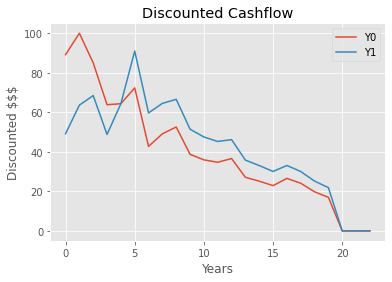

In [48]:
plt.plot(range(23), y0_disc, label="Y0")
plt.plot(range(23), y1_disc, label="Y1")

plt.title(f"Discounted Cashflow")
plt.legend()
plt.ylabel("Discounted $$$")
plt.xlabel("Years");

Since the customer ended his or her relationship after 20 years, we don't need to show the infinite cashflow, as it will be always zero from then on. Then, just like before, we can sum all the discounted cashflow.

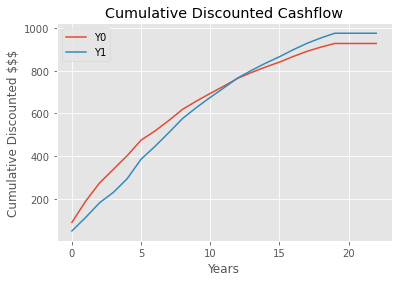

In [53]:
plt.plot(range(23), np.cumsum(y0_disc), label="Y0")
plt.plot(range(23), np.cumsum(y1_disc), label="Y1")

plt.title(f"Cumulative Discounted Cashflow")
plt.legend()
plt.ylabel("Cumulative Discounted $$$")
plt.xlabel("Years");

The sum of the discounted cashflow is so famous and usefull that it deserves it's own name: the Net Present Value (NPV) or sometimes, Lifetime Value (LTV). 

$$
NPV_i = \sum^{\infty}_{t=0}\dfrac{Profit_{it}}{(1+r)^t}
$$

If we compute the NPV of our average customer under the investment and under no investment, we can see that the investment pays off. 

In [56]:
npv0 = np.sum(y0_disc)
npv1 = np.sum(y1_disc)
print('NPV_0:', npv0)
print('NPV_1:', npv1)

NPV_0: 927.6647947920916
NPV_1: 975.5975761521427


The power of NPV comes from the fact that it encodes a meaningfull and sound economic theory. Since any company, in whichever industry, seeks to maximise profits, we can leverage NPV as a general framework for defining a reasonable outcome variable \\(Y\\). In terms of causal inference, it means that we should focus our atention on finding treatment that optimise the NPV.

But there is more. The fact that NPV agregates the time dimenstion means we no longer need make an arbitrary choice. To see that, consider the year 40 discount factor, assuming the rate is 10%. It will be \\(1/1.1^{30}=0.057\\). This means that whatever profit we have on year 30, only 6% of it will be consider in the NPV. If the profitability is constant over time, then, we can see that, with a 10% rate, 15 years will already account for more than 80% the NPV. 

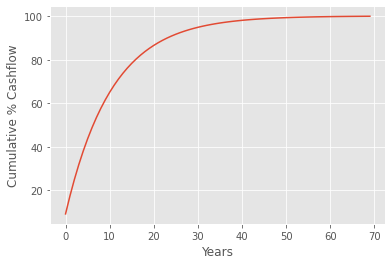

In [77]:
discounted = np.array([1/1.1**t for t in range(70)])
plt.plot(range(70), 100*discounted.cumsum()/discounted.sum())
plt.xlabel("Years")
plt.ylabel("Cumulative % Cashflow");


If the discount rate is higher, the NPV converges even faster. For instance, with a rate of 20% anualy, 9 years already account for more than 80% of the NPV.

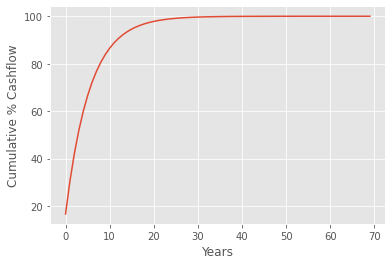

In [78]:
discounted = np.array([1/1.2**t for t in range(70)])
plt.plot(range(70), 100*discounted.cumsum()/discounted.sum())
plt.xlabel("Years")
plt.ylabel("Cumulative % Cashflow");


So, although we shoud choose the infinite timeframe to agregate our profits if we want to be precise, choosing a relative smaller timeframe will not hurt that much. Looking at plots like the above, we can made a sound judgment about what timeframe will already encompass the majority of the NPV. Personaly, I like 80%, so, if the discount rate was 10%, I would say that considering 15 years is already suficient to campture the majority of the  long term treatment effect. With that in mind, I would construct my outcome variable as

$$
Y_i = \sum^{15}_{t=0} \dfrac{Profit}{1.1^t}
$$

Once that is defined, we can procede with whatever causal inference analysis we want to do. Be it the average treatment effect

$
E[Y_1 - Y_0]
$

or heterogeneous treatment effect.

$
E[Y_1 - Y_0 | X]
$

I know what you are thinking. Alright, 15 years is already much better than infinite, but it is still a VERY long time. Most projects cannot wait that long to measure the efectviness of its treatment. Can't we reduce that for something like, a couple of months or weeks?

Unfortunatly, the answer is not definitive. It will largely depend on the dynamics of your business. Each dynamic will require different techniques and make different assumptions in order to estimate long term treatment effect. We will adress them in chapters to come. But before we close here, let's adress the elefant in the room.

## The Place for Short Term Metrics

Most companies don't use long term metrics. You see a lot of them optimising metrics like conversion in something like 2 weeks. Or purchase volume is something like one month. Or NPS is something like 1 week. Why do they do that if, in reality, they are all after profit maximisation? The answer is twofold. 

First, is due to lazyness. As we are starting to see, comig up with a reasonable long term metric is incredibly complex and most people don't want to go through all the hassle. This is a bad reason not to use long term metrics. But there is a reasonable answer too. 

Companies often make a leap of faith that these metric will eventually translate into profitability. That makes some sence. The more people buy/use/download your product (conversion), the higher your profits will likly be. The better your customer service (NPS), hopefully, the more profitable your company will be. This are often strategic thinking. Companies rarely know exacly how NPS or conversion translate to long term profitability. They just hope that it will. In this sence, short term metrics act as a sort of proxy to a long term profitability metric, which is a prety decent strategy we will look into with more detail.

There is also a statistical reason to choose other metrics other than NPV. To see this, consider what would be the impact of a very week treatment on NPV. For example, what is the impact of changing the layout of your webpage on long term profitability? Probably very small. Still, very small values over a long period of time and across milions of uses make it so that optimising even this week treatment makes sense. In fact, companies do it all the time. They optimise the layout of their product, the color, leter size... But if the impact of those treatments is very small, it will be incredibly hard to see the a statistically significant efect. However, the effect of these kind of week treatment might be stronger on metrics like acess or downloads in the next few weeks. 

[]
